c:\users\naveen anupoju\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


>expected=392.7, predicted=374.5
>expected=400.9, predicted=396.6
>expected=426.3, predicted=394.8
>expected=415.6, predicted=435.7
>expected=395.7, predicted=422.2
>expected=390.5, predicted=381.7
>expected=397.6, predicted=387.2
>expected=413.1, predicted=398.6
>expected=406.0, predicted=413.6
>expected=425.4, predicted=396.6
>expected=421.6, predicted=404.4
>expected=416.1, predicted=407.5
>expected=420.7, predicted=408.8
>expected=415.9, predicted=418.4
>expected=422.6, predicted=417.6
>expected=423.7, predicted=418.5
>expected=427.0, predicted=424.0
>expected=416.1, predicted=424.8
>expected=405.6, predicted=411.0
>expected=399.3, predicted=414.2
>expected=382.2, predicted=414.5
>expected=389.8, predicted=388.2
>expected=365.2, predicted=384.2
>expected=365.8, predicted=391.1
>expected=366.9, predicted=368.5
>expected=335.4, predicted=367.1
>expected=341.1, predicted=362.2
>expected=343.0, predicted=351.5
>expected=346.5, predicted=345.8
>expected=337.9, predicted=364.9
RMSE: 17.2

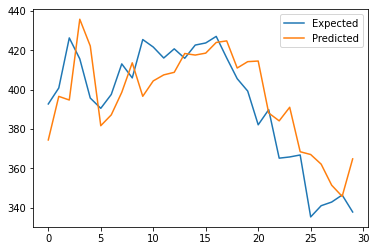

In [45]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=2000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
    error = mean_squared_error(test[:, -1], predictions,squared=False)
    return error, test[:, -1], predictions

# load the dataset
series=pd.read_excel(r'France-Emissions.xlsx',
                   index_col=0,
                   #parse_dates=True,
                   #squeeze=True,
                   header=0,
                   engine='openpyxl')
series=series[['co2']]

values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 30)
print('RMSE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()